# Preparing the dataset

##  Opening the images

In [12]:
# Import Python 3's print function and division
from __future__ import print_function, division

In [13]:
# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [15]:
# Read in our image and ROI image
img_ds = gdal.Open('data/LE70220491999322EDC01_stack.gtif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('data/training_data.gtif', gdal.GA_ReadOnly)

In [16]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

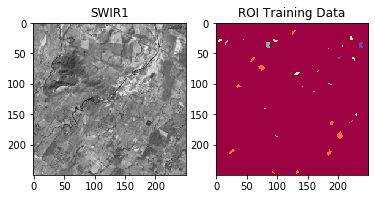

In [17]:
# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

# Pairing Y with X

In [18]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

# Mask out clouds, cloud shadows, and snow using Fmask
clear = X[:, 7] <= 1

X = X[clear, :7]  # we can ditch the Fmask band now
y = y[clear]

print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

We have 718 samples
The training data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (718, 8)
Our y array is sized: (718,)
After masking, our X matrix is sized: (718, 7)
After masking, our y array is sized: (718,)


In [19]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 70% training and 30% test

In [20]:
import pandas as pd
X_train = pd.DataFrame(X_train, columns = ['Band_1','Band_2','Band_3','Band_4','Band_5','Band_6','Band_7'])
X_test = pd.DataFrame(X_test, columns = ['Band_1','Band_2','Band_3','Band_4','Band_5','Band_6','Band_7'])
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [10]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0, 1024))
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_test  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Begin to load dataset

In [21]:
# load csv to dataframe
import pandas as pd
X_train = pd.read_csv('land_X_train.csv', sep='\t', encoding='utf-8')
X_test  = pd.read_csv('land_X_test.csv', sep='\t', encoding='utf-8')
y_train = pd.read_csv('land_y_train.csv', sep='\t', encoding='utf-8')
y_test  = pd.read_csv('land_y_test.csv', sep='\t', encoding='utf-8')

In [22]:
# # save dataframe to csv
# X_train_file = 'land_X_train.csv'
# X_test_file  = 'land_X_test.csv'
# y_train_file = 'land_y_train.csv'
# y_test_file  = 'land_y_test.csv'
# X_train.to_csv(X_train_file, sep='\t', encoding='utf-8', index=False)
# X_test.to_csv(X_test_file, sep='\t', encoding='utf-8', index=False)
# y_train.to_csv(y_train_file, sep='\t', encoding='utf-8', index=False)
# y_test.to_csv(y_test_file, sep='\t', encoding='utf-8', index=False)

In [23]:
from IPython.display import display, HTML

display(X_train[0:5])
display(X_test[0:5])
display(y_train[0:5])
display(y_test[0:5])

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7
0,975,1383,1870,2841,3475,2919,3171
1,1393,1883,2328,3410,3848,3154,3313
2,306,584,355,4152,1867,727,2537
3,285,428,257,3584,1463,541,2487
4,397,643,505,3506,2211,962,2637


,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7
0,693,895,1098,2121,3224,2682,3171
1,522,674,748,1715,909,488,2436
2,306,517,336,3811,1817,753,2537
3,306,473,277,3213,1364,488,2537
4,241,428,257,3299,1564,594,2436


,0
0,5
1,4
2,3
3,1
4,3


,0
0,4
1,2
2,1
3,1
4,1


In [24]:
X_train.agg(['min', 'max'])

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7
min,240,315,198,1250,681,331,2386
max,1642,2185,2687,4789,4548,3705,3546


# Training the Random Forest

In [25]:
import joblib
rf = joblib.load("land_random_forest.joblib")

In [26]:
# from sklearn.ensemble import RandomForestClassifier

# # Initialize our model with 500 trees
# rf = RandomForestClassifier(n_estimators=1500, max_depth=9, oob_score=True)

# # Fit our model to training data
# rf = rf.fit(X_train, y_train.values.ravel())

In [27]:
# import joblib

# # save
# joblib.dump(rf, "land_random_forest.joblib")

In [28]:
import numpy as np
np.set_printoptions(suppress=True)
total_node = 0
for tree in rf.estimators_:
#     print("Tree",i,'-----------------------------------------------------------------------------------')
#     print("Number of nodes: ", tree.estimators_[i].tree_.node_count) #Number of node
    print(tree.tree_.threshold)
    total_node += tree.tree_.node_count
print(total_node)

[ 573.    -2.   644.  3003.   351.5  384.5   -2.  4066.    -2.    -2.
  621.  2612.    -2.    -2.  2554.    -2.    -2.  1875.5   -2.    -2.
 3812.5 1185.5  670.5   -2.    -2.  1876.5 1404.5 3051.  1591.  2882.
   -2.    -2.    -2.  3099.  2926.    -2.    -2.    -2.    -2.  3430.
 1731.5   -2.  3466.5   -2.    -2.    -2.    -2. ]
[ 573.    -2.  3272.  2364.  1307.  2498.5   -2.    -2.    -2.  1234.5
   -2.  4086.5 3359.5 3027.    -2.  1470.    -2.    -2.    -2.    -2.
 1609.   374.   846.  3939.    -2.    -2.    -2.    -2.  3761.5 3289.5
   -2.    -2.    -2. ]
[1904.5 2612.  1874.5   -2.    -2.   558.    -2.    -2.  3003.  1427.
  608.   384.5   -2.    -2.  2612.  3939.    -2.    -2.    -2.    -2.
 1234.5   -2.  3813.  2933.    -2.  3004.5   -2.  3099.    -2.    -2.
   -2. ]
[ 415.   561.5   -2.   338.5  780.    -2.    -2.    -2.  2579.   629.
  610.5   -2.  1400.    -2.    -2.   714.5   -2.   538.5 1560.5   -2.
   -2.  1823.5   -2.    -2.  3033.5 2745.5   -2.    -2.  3242.  2351.5
 321

[1865.5  883.5 1874.5   -2.    -2.   642.5   -2.    -2.  3003.   608.
 2562.  3981.5   -2.    -2.    -2.  2867.    -2.    -2.  1137.5 1961.5
   -2.    -2.  1339.5   -2.  2432.  3194.5  955.    -2.    -2.    -2.
 3285.5   -2.    -2. ]
[ 409.  1829.    -2.  2562.    -2.    -2.  3159.5 1846.5   -2.  2651.5
 1205.   621.    -2.    -2.    -2.  3543.5 1108.5   -2.  1762.5 1408.
   -2.  1476.    -2.    -2.  2990.5   -2.    -2.  3147.    -2.  2867.5
   -2.    -2.   742.5 2612.   618.5   -2.    -2.    -2.  3452.5 1926.5
   -2.    -2.    -2. ]
[ 573.    -2.  3003.  1215.5  744.   374.   424.5   -2.    -2.    -2.
 1749.5   -2.    -2.  1340.5   -2.    -2.  1941.    -2.  2910.5  929.5
 2457.    -2.    -2.  1415.5   -2.    -2.  2666.5   -2.  2432.    -2.
   -2. ]
[ 374.  4010.    -2.    -2.  1331.5 1676.    -2.    -2.  1137.5  954.
   -2.  1961.5   -2.    -2.   913.  2969.5   -2.    -2.  3147.   963.
   -2.  3083.5   -2.    -2.  1519.5 2839.    -2.  3480.    -2.    -2.
   -2. ]
[ 434.  3996.    -2. 

[ 573.    -2.  2628.5  607.5   -2.  1980.5  608.   595.5   -2.    -2.
   -2.    -2.   700.    -2.  3824.5 3360.  3336.5  774.5   -2.  2395.
   -2.  2364.    -2.    -2.  3452.5   -2.    -2.  3288.    -2.    -2.
 3075.    -2.    -2. ]
[ 573.    -2.  3003.   647.5   -2.  1215.5  654.5 3939.   384.    -2.
   -2.    -2.    -2.  1316.    -2.    -2.  3312.5 1185.5 3194.5   -2.
   -2.   920.5   -2.    -2.  2832.    -2.  1519.5 2984.  3637.5 2706.5
   -2.    -2.    -2.    -2.  2631.5   -2.    -2. ]
[1904.5  574.    -2.   421.    -2.    -2.  1318.5 3939.   923.5   -2.
   -2.    -2.  2179.5 2745.5   -2.    -2.  2846.5  896.  3098.5   -2.
   -2.    -2.  1262.  3644.    -2.  3147.    -2.    -2.  3761.5 3429.5
   -2.    -2.    -2. ]
[ 573.    -2.  2615.  2623.    -2.   434.  3911.    -2.    -2.    -2.
  896.  1961.5   -2.    -2.  3242.  2910.5   -2.  1447.5   -2.    -2.
 1530.  3478.5   -2.    -2.  3453.    -2.    -2. ]
[ 726.5 1685.    -2.    -2.  2578.5  644.   374.  2562.  3953.    -2.
   -2.  20

[ 752.5  344.    -2.   573.    -2.   607.5   -2.    -2.  2592.   368.5
  354.5 2562.    -2.  2005.5   -2.    -2.    -2.   766.5 3894.    -2.
   -2.    -2.   896.  3194.5 1990.5   -2.    -2.    -2.  1010.  1240.5
 1427.5 3051.    -2.    -2.    -2.  2910.5   -2.    -2.  3787.5 3430.
 1048.    -2.  3289.5 1731.5   -2.    -2.    -2.    -2.    -2. ]
[ 608.  4024.5  417.5   -2.    -2.    -2.  3003.   644.   607.5   -2.
 1564.    -2.   374.   846.    -2.    -2.    -2.  2857.    -2.    -2.
  896.  2757.5   -2.  3194.5   -2.  2589.    -2.    -2.  1448.5 3051.
   -2.  3312.5 3194.5 3069.5   -2.    -2.  3075.    -2.    -2.    -2.
 3145.    -2.  3061.    -2.  3396.    -2.    -2. ]
[ 573.    -2.  3641.  2579.  1885.5   -2.    -2.   727.5 3194.5   -2.
   -2.  2918.5 3335.5   -2.    -2.  1262.  2965.5 3682.5   -2.    -2.
   -2.  1731.5   -2.  2034.5 3242.    -2.    -2.  3836.5   -2.    -2.
  434.  2106.5 3939.    -2.    -2.  3911.    -2.    -2.    -2. ]
[ 573.    -2.  3003.  3159.5 1769.    -2.    -2

[ 726.5  575.5   -2.    -2.   723.5  573.    -2.   374.  2562.    -2.
   -2.    -2.  3003.  1131.   534.    -2.    -2.    -2.   896.  2695.5
   -2.    -2.  3383.  3115.  2940.    -2.  3289.5 3688.    -2.    -2.
   -2.  3761.5   -2.  1184.  2867.5   -2.    -2.    -2.    -2. ]
[ 726.5  807.5   -2.    -2.  3003.   608.   308.5   -2.    -2.   644.
 2324.    -2.    -2.  1862.5   -2.    -2.  1185.5 2757.5   -2.    -2.
 3824.5 3336.5 3523.5 3051.  2940.5   -2.    -2.    -2.    -2.    -2.
 2867.    -2.    -2. ]
[1879.5 2034.    -2.    -2.  3286.  3033.5  667.   501.5   -2.    -2.
 2305.5   -2.    -2.   896.  3194.5   -2.  2589.    -2.    -2.  2933.
 3335.5   -2.    -2.  3145.    -2.  1546.5   -2.    -2.  2018.5 2153.
 3911.    -2.    -2.    -2.  3061.  2851.5   -2.    -2.    -2. ]
[ 726.5  593.5   -2.    -2.  1331.5  573.    -2.  1626.    -2.   608.
  404.    -2.    -2.    -2.   700.    -2.  3115.  2946.  1137.5 1990.5
   -2.    -2.  3517.5 3335.5   -2.    -2.    -2.  1436.5 3618.    -2.
 1384

[ 371.5  394.5 4321.5   -2.    -2.   608.    -2.    -2.  3003.   629.
  374.   413.5   -2.    -2.    -2.  1244.  2495.5   -2.    -2.    -2.
  695.  1961.5   -2.    -2.  3242.  3062.  3026.5   -2.  3182.5   -2.
   -2.   901.5   -2.  3128.    -2.  4062.    -2.    -2.  1509.5 2228.
   -2.  1862.    -2.    -2.  3206.    -2.    -2. ]
[ 561.5   -2.  2578.5  647.5   -2.  1215.5  629.  2043.5   -2.   793.
   -2.    -2.  2623.    -2.    -2.    -2.   711.    -2.  2846.5 2395.
 3123.    -2.    -2.    -2.  1438.5 3051.  2940.5   -2.    -2.    -2.
 3452.5   -2.    -2. ]
[ 608.  1865.5   -2.   766.5 3981.5   -2.    -2.    -2.  3557.5  520.
 2664.   618.    -2.    -2.    -2.  2041.    -2.  3030.  2395.  1030.5
   -2.    -2.  2285.    -2.  1404.5 3449.5   -2.    -2.  1048.    -2.
   -2.  3147.    -2.  2546.5   -2.  2631.5   -2.    -2.  1069.  2612.
  424.5   -2.   846.    -2.    -2.    -2.    -2. ]
[ 371.  1904.5   -2.   793.    -2.  2537.    -2.    -2.  3003.   674.
  423.5   -2.    -2.   644.  1829.

[ 587.5 1865.5   -2.   753.5 3981.5   -2.    -2.    -2.  3003.  1689.
   -2.   351.5 2562.    -2.    -2.    -2.  2509.  1875.5   -2.  1030.5
   -2.    -2.  3242.  3961.5 3260.5  863.    -2.    -2.  3449.5  952.
 3099.    -2.    -2.    -2.    -2.    -2.  2432.    -2.  2002.5   -2.
   -2. ]
[1917.5  585.5   -2.   452.5   -2.    -2.  1331.5 1980.5  617.5   -2.
   -2.   351.5 2043.5   -2.    -2.    -2.  1137.5 3194.5   -2.  1059.5
   -2.    -2.  3242.  3051.    -2.  2212.5 3298.5   -2.    -2.    -2.
 1300.    -2.  3061.    -2.    -2. ]
[ 415.  4222.5   -2.    -2.  3456.5  896.  2881.   453.   478.5   -2.
   -2.    -2.  1961.5   -2.    -2.  2846.5   -2.  3196.5 3194.5 1764.
   -2.    -2.    -2.  1436.    -2.  2394.5 2299.    -2.    -2.    -2.
  608.    -2.  1415.   629.  2081.    -2.    -2.    -2.    -2. ]
[ 415.  1853.    -2.   766.5   -2.  2562.    -2.    -2.  2629.  1903.5
 1461.5   -2.    -2.   608.    -2.    -2.   711.    -2.  3242.  3986.5
 3449.5 2940.  2395.  3147.    -2.    -2.    

[ 371.  2004.   618.5   -2.    -2.    -2.  1331.5  644.  1752.   611.
   -2.    -2.   374.   413.5   -2.    -2.    -2.    -2.  1137.5  572.5
   -2.  1030.5   -2.    -2.  3242.  2940.5   -2.    -2.  1530.  2938.
 2884.5   -2.    -2.    -2.  3467.5   -2.    -2. ]
[1904.5 2612.  1874.5   -2.   573.    -2.    -2.   549.    -2.    -2.
 3003.  1887.  3911.   469.5   -2.    -2.    -2.    -2.   695.  1990.5
   -2.    -2.  2846.5   -2.  3296.  2965.5 1829.5  952.5   -2.    -2.
   -2.    -2.    -2. ]
[ 752.5  883.5   -2.  4138.    -2.    -2.   644.  2745.5 1637.   369.
 4052.    -2.    -2.   805.5 2760.    -2.    -2.    -2.    -2.    -2.
 3824.5 3449.5 3099.  1584.    -2.  1316.5   -2.   963.    -2.    -2.
 2164.5   -2.  1382.5   -2.  2582.    -2.    -2.  1480.5   -2.  3202.5
   -2.    -2.   902.5   -2.    -2. ]
[ 576.5   -2.  1331.5  618.5  846.   793.    -2.   608.    -2.    -2.
   -2.  3108.    -2.    -2.  1137.5 1961.5   -2.    -2.  1339.5 1601.5
 1218.5 2898.    -2.    -2.    -2.    -2.  32

[1865.5 2117.  1875.    -2.  1146.5   -2.    -2.    -2.  1331.5  595.5
  780.  3981.5   -2.    -2.    -2.   434.  2094.   424.5   -2.    -2.
 3911.    -2.    -2.    -2.   711.    -2.  3756.  2846.5 2774.  2642.
 3098.5   -2.   896.    -2.    -2.   919.    -2.    -2.  1234.5   -2.
   -2.  3374.5 1848.    -2.    -2.  3161.5 1791.  1361.    -2.    -2.
 1300.    -2.    -2.    -2.  3147.    -2.    -2. ]
[1865.5  583.5   -2.    -2.  2629.  2612.  3939.    -2.    -2.    -2.
 3374.5 1743.5 1875.5   -2.  1990.5   -2.  2759.5  973.5   -2.    -2.
   -2.    -2.  3030.  3600.  1404.5 3449.5  931.    -2.  2897.    -2.
   -2.    -2.  3360.  1300.    -2.    -2.    -2.    -2.  3812.5 3406.5
 3509.5   -2.    -2.    -2.    -2. ]
[1865.5  575.5   -2.    -2.  3003.   608.  3981.5   -2.    -2.  1408.
  374.   424.5   -2.    -2.    -2.    -2.   727.5  562.5   -2.   807.5
   -2.    -2.  1251.5   -2.  2910.5   -2.  2984.  3360.  1005.5   -2.
   -2.    -2.    -2. ]
[ 726.5  807.5   -2.    -2.  3003.   846.   60

[ 587.5   -2.  1331.5  644.   744.   555.5   -2.   374.  2562.    -2.
 2081.    -2.    -2.    -2.  1711.5   -2.    -2.    -2.   711.    -2.
 3030.  3099.  2654.5   -2.    -2.  3787.5 2903.   695.  2019.5   -2.
   -2.    -2.  3430.    -2.    -2.  3799.5   -2.    -2.  2875.5   -2.
 2546.5   -2.  3836.5   -2.    -2. ]
[1865.5  631.    -2.    -2.  2578.5 1991.5 3953.    -2.    -2.   330.5
   -2.    -2.  1185.5 3194.5   -2.    -2.  2910.5 1437.    -2.    -2.
 1969.5 1448.5 1447.5   -2.    -2.    -2.  3799.    -2.    -2. ]
[ 726.5  432.    -2.    -2.  3003.  1980.5 3953.  1487.    -2.    -2.
   -2.   774.5  351.5 2043.5   -2.    -2.  3953.  3730.    -2.    -2.
   -2.    -2.  2709.  2395.  1990.5   -2.   896.    -2.    -2.   605.5
   -2.    -2.  1427.5   -2.  3336.5 3799.5 2429.    -2.  2813.5 3424.5
   -2.    -2.    -2.  3075.    -2.    -2.    -2. ]
[ 394.5  740.   573.    -2.    -2.   573.    -2.    -2.  1331.5 2612.
 3939.   604.    -2.    -2.    -2.  2567.    -2.    -2.  2390.5  711.
   -

[ 779.5 1879.5  573.    -2.   607.5   -2.    -2.    -2.   742.5  608.
   -2.    -2.  1307.   893.5   -2.  1136.    -2.    -2.  2377.5 2305.5
   -2.    -2.  2846.5  695.  3194.5   -2.    -2.    -2.  3253.5 1943.
   -2.  3312.    -2.    -2.  3452.5   -2.    -2. ]
[ 409.   726.5   -2.   376.5 2562.    -2.   363.    -2.    -2.  3823.5
   -2.    -2.  3003.   687.   533.5   -2.    -2.  1174.5  762.  3169.
   -2.  2612.   608.    -2.    -2.    -2.   927.    -2.    -2.  2882.
 1887.    -2.    -2.    -2.  1849.5   -2.  2910.5 3350.   929.5 1961.5
   -2.    -2.    -2.  1063.5   -2.    -2.  3008.5 1877.    -2.  3452.5
   -2.    -2.  2546.5   -2.  3467.5   -2.    -2. ]
[1904.5  427.5  573.    -2.    -2.    -2.  3003.  3215.5 1068.    -2.
   -2.  3911.  3758.    -2.    -2.    -2.  1137.5 1961.5   -2.    -2.
 3030.  1609.  2443.5   -2.  1294.    -2.    -2.  1469.5   -2.  1937.5
 2793.    -2.    -2.    -2.  3170.5   -2.  3755.  3383.    -2.    -2.
   -2. ]
[ 587.5 1865.5   -2.  3981.5   -2.    -2.  2

[ 374.  4137.5   -2.    -2.  3358.5  684.   667.5   -2.    -2.  3360.
 1948.    -2.   695.  2881.    -2.  1961.5   -2.    -2.  3051.  3500.
   -2.    -2.  3233.  3099.    -2.    -2.    -2.    -2.  1448.    -2.
 3761.5   -2.    -2. ]
[ 573.    -2.  2579.  2567.    -2.   846.   424.5   -2.   362.5   -2.
   -2.    -2.  1849.5   -2.  3141.5  941.  2298.5   -2.    -2.  1404.5
  984.5 3097.5   -2.    -2.  3362.    -2.    -2.  1877.    -2.  3761.5
   -2.    -2.    -2. ]
[ 608.  3996.   417.5   -2.    -2.    -2.  2578.5  555.5   -2.  1676.
   -2.   434.   629.  2562.    -2.    -2.    -2.    -2.  1849.5   -2.
 2918.5  706.5 1040.    -2.    -2.  2885.5 3467.    -2.  1021.    -2.
   -2.    -2.  2029.    -2.  3061.  3289.5 2706.5   -2.    -2.    -2.
   -2. ]
[ 371.  3996.    -2.   574.    -2.    -2.  1331.5 1829.   427.5   -2.
   -2.    -2.   700.    -2.  2918.5 1137.5 3098.5   -2.    -2.    -2.
 1990.5 3018.5 3004.5   -2.    -2.    -2.  1731.5   -2.  3761.5 1786.
   -2.    -2.    -2. ]
[1853.  26

[2612.  1829.   634.    -2.    -2.   846.  3953.    -2.    -2.  2562.
   -2.    -2.   762.   621.   524.    -2.    -2.  2930.   542.    -2.
   -2.    -2.  2519.5 3224.5   -2.    -2.  2179.5   -2.  3149.  1514.5
 3099.  2615.5   -2.    -2.   727.5  642.5   -2.    -2.  3036.    -2.
   -2.  2846.5   -2.  1915.  3217.    -2.    -2.  3061.    -2.    -2.
   -2. ]
[ 752.5  394.5   -2.  2460.    -2.  1802.5   -2.    -2.  1331.5  618.5
 2562.    -2.    -2.  1174.5  872.    -2.   654.5   -2.    -2.  2568.5
   -2.    -2.  3033.5 3194.5   -2.    -2.  2846.5 3274.5 3058.    -2.
  717.    -2.    -2.    -2.  1530.  1838.5   -2.  2918.5   -2.  3438.5
 3383.    -2.    -2.    -2.  3836.5   -2.    -2. ]
[ 573.    -2.  1331.5  608.  1955.5   -2.    -2.   647.5   -2.  1627.5
   -2.    -2.   551.    -2.  1016.   941.   642.5   -2.    -2.  3949.5
 3051.  2969.5   -2.    -2.  2522.5 3211.    -2.    -2.  3449.5   -2.
   -2.    -2.  3812.5 1969.5 1611.5 1915.    -2.    -2.  3480.    -2.
 3611.5   -2.    -2.    

[ 726.5  427.5   -2.    -2.  2579.   434.   561.5   -2.   819.5   -2.
 4009.5   -2.    -2.  2666.5   -2.   362.5   -2.    -2.   941.   711.5
   -2.  1918.5   -2.    -2.  3030.  1404.5 3010.5   -2.  2998.    -2.
   -2.  1877.    -2.  3773.5 3466.5   -2.    -2.    -2.  3147.    -2.
 1540.    -2.  3259.5   -2.    -2. ]
[ 752.5  807.5   -2.  3996.    -2.    -2.  3158.5 1137.5 2832.    -2.
 1961.5   -2.    -2.  3030.  2562.5 2020.    -2.  2536.    -2.    -2.
 3517.5 2846.5   -2.  3429.5   -2.    -2.    -2.  1505.    -2.    -2.
 1913.   608.    -2.   374.   424.5   -2.    -2.    -2.  3711.5 1300.
   -2.    -2.    -2. ]
[1865.5  583.5   -2.    -2.  1331.5 3042.5   -2.   351.5 3981.5   -2.
   -2.    -2.  1137.5 3194.5   -2.  2923.    -2.    -2.  1404.5 2910.5
   -2.    -2.  3008.5 1877.    -2.  1279.5   -2.  1861.5   -2.    -2.
   -2. ]
[ 371.5  608.   752.5   -2.  4151.    -2.    -2.    -2.  3003.  1803.5
  594.5   -2.  2348.    -2.    -2.  3159.5   -2.    -2.  3033.5 2179.5
 3147.    -2.    

[1917.5  453.    -2.    -2.  2578.5 1991.5  351.5 2562.    -2.    -2.
   -2.   454.5 3981.    -2.    -2.    -2.  1137.5 1961.5   -2.    -2.
 2846.5   -2.  1969.5 1990.5 2846.  2926.    -2.    -2.    -2.  1374.
   -2.    -2.  3467.5   -2.    -2. ]
[ 713.5  575.5   -2.    -2.  2579.  3042.5  950.    -2.    -2.  1816.
   -2.  1955.5 3853.5   -2.    -2.  3911.  3758.    -2.    -2.    -2.
  551.    -2.   954.5 2924.5  684.5 2457.    -2.    -2.    -2.    -2.
 3030.  1937.5 2813.  3099.    -2.  3278.5   -2.    -2.  2175.  1073.5
   -2.    -2.    -2.    -2.  3135.5 2888.5   -2.    -2.    -2. ]
[ 752.5 1879.5 1874.5   -2.    -2.    -2.  3003.  1905.   606.    -2.
   -2.  1874.  3042.5   -2.   374.   819.5   -2.  4052.    -2.    -2.
   -2.    -2.  1875.5   -2.  3194.5 2955.  3312.5 1137.5  631.5   -2.
   -2.    -2.    -2.  2495.    -2.    -2.  2659.5   -2.  1300.    -2.
 3061.    -2.    -2. ]
[ 608.  4138.    -2.    -2.  2579.   523.   629.  3939.    -2.    -2.
   -2.  1775.5   -2.    -2.   551.

[ 779.5  593.5  371.5  409.    -2.    -2.  3738.5   -2.    -2.    -2.
  670.5 3003.   644.   608.    -2.   374.  2094.    -2.    -2.   805.5
 1602.    -2.    -2.    -2.    -2.  2745.5   -2.    -2.  2910.5 1205.
   -2.  2846.5   -2.  3580.  2793.    -2.    -2.    -2.  2228.  1010.5
 1774.    -2.    -2.    -2.  3761.5   -2.    -2. ]
[1879.5 2102.5 2461.5   -2.    -2.    -2.  2652.  1991.5  573.    -2.
   -2.  3911.   911.    -2.    -2.    -2.   962.5   -2.  1061.   984.5
 3986.5 3374.5 3099.    -2.    -2.  2813.5 3462.    -2.    -2.    -2.
   -2.  2707.5   -2.  1360.5   -2.  1437.    -2.    -2.  2759.    -2.
 3161.5 3140.5   -2.    -2.    -2. ]
[ 608.   371.    -2.    -2.  1331.5 1688.5   -2.  3911.   459.5   -2.
   -2.    -2.   706.5  711.    -2.  3098.5   -2.    -2.  2846.5   -2.
 1990.5 1274.5 2681.5   -2.    -2.    -2.  1731.5   -2.  1551.  2432.
 2956.5   -2.    -2.  1488.5   -2.    -2.    -2. ]
[ 371.5 3992.5   -2.   674.    -2.    -2.  3272.  1137.5  537.5   -2.
  712.5 2602.5  46

[ 573.    -2.  3003.  1551.5   -2.   774.5  374.   424.5   -2.    -2.
   -2.    -2.   551.    -2.  1061.   695.   962.5   -2.    -2.  2910.5
   -2.  1810.5   -2.    -2.  3242.  3438.    -2.    -2.  2432.    -2.
 2470.    -2.    -2. ]
[1853.   514.    -2.    -2.  2579.   454.5 3953.    -2.    -2.    -2.
 2179.5   -2.  3824.5  695.  2923.    -2.    -2.  2846.5   -2.  3008.5
 1841.    -2.  1731.5   -2.    -2.  2012.5   -2.    -2.  3855.5 3096.5
   -2.    -2.    -2. ]
[ 573.    -2.  2579.   644.  2661.5 2683.    -2.   608.   793.    -2.
   -2.    -2.  2809.  1665.    -2.    -2.    -2.    -2.  1875.5   -2.
 3289.5 2562.5 1350.5 2236.5   -2.  1234.5   -2.    -2.    -2.   706.5
   -2.  2882.    -2.   965.5   -2.  1300.    -2.    -2.  2013.5   -2.
 2631.5   -2.    -2. ]
[ 374.   573.    -2.   435.  3939.    -2.    -2.    -2.  3003.  3159.5
 1536.    -2.  1571.5   -2.    -2.  1829.    -2.    -2.   711.    -2.
 2910.5  896.  1961.5   -2.    -2.    -2.  2432.  2706.5 2482.5   -2.
   -2.  2228.   

[ 726.5  533.5   -2.    -2.  3003.   409.  3896.5   -2.    -2.  1196.5
 3169.   613.5   -2.    -2.  2612.   351.5  435.    -2.    -2.    -2.
   -2.  1862.5   -2.    -2.   876.    -2.  1876.5  688.5   -2.  3374.5
  653.    -2.   684.5   -2.  3099.    -2.    -2.  1416.    -2.    -2.
 2918.5   -2.  3480.    -2.  3008.5 1786.    -2.    -2.    -2. ]
[ 752.5 2048.    -2.   585.5   -2.    -2.  2578.5 1905.  2515.    -2.
   -2.   464.  3911.    -2.    -2.    -2.   711.    -2.  2910.5 3335.5
 2774.   896.   642.5   -2.    -2.    -2.    -2.    -2.  1991.5 2965.5
 3075.    -2.  1437.    -2.    -2.    -2.  3259.5   -2.    -2. ]
[ 726.5 1844.    -2.    -2.  1345.   368.5 2562.   766.5 2512.   329.5
   -2.    -2.  1829.    -2.    -2.    -2.    -2.   563.5   -2.  2554.5
   -2.   434.   374.  4081.    -2.    -2.    -2.    -2.   929.5 1990.5
   -2.    -2.  2918.5   -2.  3755.  1293.    -2.  3430.    -2.    -2.
   -2. ]
[ 779.5 2033.5   -2.  1879.5   -2.    -2.  3272.   551.   536.5   -2.
   -2.  2846.5

[ 573.    -2.   723.5 2207.5   -2.  2612.   444.5 2106.5   -2.   640.5
   -2.    -2.   363.    -2.    -2.    -2.  1136.  1786.    -2.    -2.
 3312.5 2757.5 2978.    -2.    -2.   572.5   -2.  3098.5  920.5   -2.
   -2.  3194.5   -2.  2609.5   -2.    -2.  2933.  2294.5   -2.  1042.5
   -2.    -2.  3398.5   -2.  3015.5 2203.5 3688.    -2.    -2.    -2.
   -2. ]
[ 394.5 1854.5   -2.    -2.  3003.   607.5   -2.   434.  2562.    -2.
 4066.    -2.    -2.  1701.5   -2.   363.    -2.   838.    -2.    -2.
  695.    -2.  1251.5   -2.  2918.5 3312.    -2.    -2.  1969.5   -2.
 3467.5   -2.    -2. ]
[1904.5  578.    -2.    -2.   645.5  422.5  319.5  573.    -2.    -2.
 2702.5 2106.5   -2.   459.    -2.    -2.    -2.   492.  2906.    -2.
   -2.   626.    -2.  1051.    -2.    -2.  2910.5  706.5   -2.  3335.5
   -2.    -2.  3008.5 1877.    -2.  1786.  1731.5   -2.    -2.    -2.
   -2. ]
[ 587.5  573.    -2.  3967.5   -2.    -2.  3003.  1119.5 1676.    -2.
 2612.  2106.5 3939.    -2.    -2.    -2.    -

[ 394.5  740.  1816.5   -2.   374.5   -2.    -2.   573.    -2.    -2.
 3003.   805.5 3710.5 2612.    -2.   578.    -2.    -2.    -2.  1887.
  608.    -2.  2623.    -2.   629.5 2081.    -2.    -2.    -2.    -2.
 2179.5   -2.  3289.5  896.  1976.5   -2.    -2.  2954.5   -2.  1470.
   -2.  3536.    -2.    -2.  2228.    -2.  1374.    -2.  3798.5   -2.
   -2. ]
[ 573.    -2.  3471.  1875.5 2664.  2567.    -2.    -2.    -2.  2933.
  929.5 2298.5   -2.    -2.  3219.5 3335.5   -2.    -2.    -2.  1241.5
   -2.  2489.  3517.5 3383.    -2.    -2.    -2.  3193.5   -2.    -2.
  964.  2081.5 3939.    -2.    -2.    -2.    -2. ]
[ 394.5 1917.5  350.5   -2.   573.    -2.    -2.  2562.    -2.   618.5
   -2.    -2.  1331.5 3169.   558.    -2.    -2.  3939.   897.5   -2.
   -2.    -2.   929.5 2745.5   -2.    -2.  3824.5  984.5 2245.5   -2.
 3449.5 1350.5   -2.  3099.    -2.    -2.    -2.  2998.  1305.5   -2.
 2898.5   -2.  2977.5   -2.    -2.  1861.5 3218.5   -2.    -2.    -2.
 2853.    -2.    -2. ]
[ 415

[ 374.  1865.5   -2.   424.5  819.5   -2.   630.    -2.    -2.    -2.
 3003.  1752.  2557.    -2.    -2.  3259.    -2.    -2.   551.    -2.
 1061.  3099.  1327.5 2813.5   -2.    -2.    -2.   896.  1040.    -2.
   -2.  2939.    -2.  1810.5   -2.    -2.  3289.5 3623.5   -2.    -2.
 3336.5 3009.    -2.  3798.5   -2.    -2.    -2. ]
[ 374.   639.5  740.    -2.  4151.    -2.    -2.    -2.  3003.  1119.5
 3211.  2557.    -2.    -2.  1854.    -2.    -2.  1340.5   -2.    -2.
  941.   551.    -2.  2923.    -2.    -2.  1448.5 1262.    -2.  1273.5
   -2.  2675.5   -2.  4049.5   -2.    -2.  2759.    -2.  1469.5   -2.
 2099.    -2.    -2. ]
[1905.   533.5   -2.    -2.  2615.   374.   819.5  384.5   -2.  2537.
   -2.    -2.  2016.5   -2.  2056.    -2.    -2.    -2.   896.    -2.
 3430.  3787.5 3051.  3500.    -2.    -2.  1010.  3012.    -2.    -2.
 3466.5 1437.    -2.    -2.    -2.  1578.5 3986.5   -2.    -2.    -2.
   -2. ]
[ 371.5 3992.5   -2.    -2.   762.  3155.  2807.    -2.    -2.   374.
 2562

[ 394.5  740.   350.5   -2.   573.    -2.    -2.  4009.    -2.    -2.
  656.  3098.5 2906.   393.5   -2.    -2.   551.    -2.    -2.  1803.5
   -2.    -2.  2846.5 3350.   896.    -2.   890.5   -2.    -2.    -2.
 3188.5 2933.  2846.    -2.  2925.    -2.    -2.    -2.  1969.5 3699.
 3367.5   -2.    -2.    -2.  2631.5 3193.5   -2.    -2.    -2. ]
[ 573.    -2.  2578.5  644.   724.5  374.  3967.    -2.    -2.    -2.
  871.5   -2.    -2.    -2.   896.  2745.5   -2.    -2.  3242.  1251.5
   -2.  2495.    -2.  3075.  1273.5   -2.    -2.    -2.  3202.5   -2.
 3452.5   -2.    -2. ]
[ 434.  3968.    -2.  2512.   727.    -2.    -2.    -2.  2578.5 1678.
   -2.   363.    -2.    -2.  1915.    -2.  2910.5  717.   653.    -2.
   -2.  3492.  3335.5   -2.    -2.    -2.  3348.5 1158.5   -2.    -2.
 3761.5 1786.  1915.    -2.  1114.    -2.    -2.  3146.    -2.    -2.
   -2. ]
[1879.5  419.  4021.    -2.    -2.    -2.  2578.5 3042.5   -2.  3911.
 2139.5   -2.    -2.    -2.  1836.    -2.  2910.5  896.  2298

[ 371.5 1904.5   -2.  2562.    -2.    -2.   649.5 2652.5  674.   593.5
   -2.    -2.   989.5 3444.   593.    -2.    -2.   434.   424.5   -2.
   -2.    -2.    -2.  2305.5   -2.    -2.  2933.  2351.5  896.  2342.
   -2.    -2.    -2.  3335.5   -2.    -2.  2432.  2965.5 3611.5 1536.
   -2.  2079.5   -2.    -2.    -2.    -2.  3424.5   -2.    -2. ]
[ 573.    -2.   723.5  899.  3939.    -2.    -2.    -2.  4052.   538.5
  884.5   -2.    -2.  2924.5 1612.5   -2.  3350.   695.  1990.5   -2.
   -2.    -2.    -2.  3008.5 3618.  2299.    -2.    -2.    -2.    -2.
   -2. ]
[ 752.5 1874.5   -2.  1829.    -2.  1879.5  573.    -2.    -2.    -2.
 2579.   608.   384.5  355.5   -2.    -2.    -2.  2567.    -2.   434.
 2081.    -2.  2661.  2562.    -2.    -2.    -2.    -2.   711.    -2.
 3430.  1274.5 3051.    -2.  1137.5  807.5   -2.    -2.  2926.    -2.
   -2.  3812.5 2495.    -2.  1745.5   -2.  3075.5   -2.    -2.    -2.
   -2. ]
[ 726.5  419.    -2.    -2.  1331.5  338.5  573.    -2.    -2.   608.
   -2

[ 595.5   -2.  1331.5 1638.5   -2.  2612.  3939.    -2.    -2.    -2.
  929.5 2033.5   -2.  1990.5   -2.    -2.  3242.  3003.    -2.  2924.5
   -2.  1802.5   -2.  2212.5   -2.    -2.  1300.    -2.  2133.    -2.
 1509.5   -2.  2631.5   -2.    -2. ]
[ 576.5   -2.  3003.  3215.5 2505.    -2.    -2.   608.    -2.   374.
  424.5   -2.    -2.    -2.  2179.5   -2.  3787.5 3430.   695.   642.5
   -2.    -2.  2495.  3110.5   -2.    -2.  1251.    -2.  1697.5   -2.
   -2.    -2.    -2. ]
[1904.5 2102.5  357.5   -2.    -2.  1878.    -2.   362.5   -2.    -2.
 2579.   330.5   -2.    -2.   885.5 1918.5   -2.    -2.  1050.  3051.
 2536.    -2.    -2.  3986.5   -2.    -2.  3008.5 1180.    -2.    -2.
 2023.5   -2.  3467.5   -2.    -2. ]
[ 371.5 4020.5   -2.    -2.  3003.  1130.5 3017.5  577.5   -2.    -2.
   -2.  2436.5   -2.    -2.   896.  1875.5   -2.   962.5   -2.    -2.
 2910.5 1042.5   -2.    -2.  3182.5 2933.  3170.5   -2.    -2.  2991.
 3682.5   -2.    -2.    -2.  3008.5   -2.    -2. ]
[1865.5 20

[1879.5  533.5  573.    -2.    -2.    -2.  1331.5  351.5  819.5  793.
   -2.    -2.    -2.  3911.   459.    -2.    -2.    -2.   711.    -2.
  984.5 1137.5  807.5   -2.    -2.  3986.5 2443.5   -2.    -2.    -2.
 3787.5 3644.  3218.5 3235.    -2.    -2.    -2.    -2.    -2. ]
[1955.5  385.    -2.   432.    -2.    -2.  2579.  3042.5   -2.   454.5
  608.    -2.    -2.    -2.  2179.5   -2.  3383.   908.  1918.5   -2.
   -2.  3812.5 2495.  2796.5   -2.    -2.  2079.5   -2.  2851.5   -2.
   -2.  2853.    -2.    -2.    -2. ]
[ 587.5   -2.  1331.5 2623.    -2.   374.  4066.    -2.    -2.    -2.
  717.    -2.  3336.5 2631.5 2910.5   -2.  1383.    -2.  3193.5 3461.
   -2.    -2.    -2.    -2.    -2. ]
[ 608.   573.    -2.  1917.5   -2.    -2.  2579.  2623.    -2.  3939.
  635.    -2.    -2.    -2.   541.    -2.  3242.  3051.    -2.   896.
  642.5   -2.    -2.  3986.5 1284.    -2.  3069.5   -2.    -2.    -2.
 3202.5   -2.  3573.5   -2.  3452.5 1851.    -2.    -2.    -2. ]
[ 394.5  350.5 4350.    -

[ 576.5   -2.   762.  2930.   607.5   -2.   374.   846.   435.    -2.
   -2.    -2.    -2.    -2.  1280.5 2975.    -2.    -2.  1137.5 1990.5
   -2.    -2.  2846.5   -2.  1943.    -2.  3242.    -2.  1719.  1697.5
   -2.    -2.  1551.    -2.    -2. ]
[ 371.   726.5   -2.   608.   573.    -2.  1943.    -2.    -2.    -2.
 3003.   660.5  427.5   -2.    -2.  1196.5  564.5   -2.  1676.    -2.
   -2.  2882.    -2.    -2.  3099.  2589.5   -2.    -2.  1042.   929.5
  830.  1875.5   -2.    -2.    -2.  1240.5   -2.  1263.    -2.   944.
 3180.5   -2.    -2.    -2.  1436.5   -2.  3811.    -2.    -2. ]
[ 573.    -2.  3159.5 1137.5 2745.5 2041.    -2.    -2.   954.    -2.
 1030.5   -2.    -2.  3194.5 3051.  2654.5 2493.    -2.    -2.    -2.
 3298.5   -2.    -2.  2609.5   -2.    -2.  1609.  2612.  2043.5   -2.
  351.5   -2.   629.5 2537.    -2.    -2.    -2.    -2.  1530.  3367.
   -2.    -2.  1613.    -2.    -2. ]
[ 374.   573.    -2.  3939.    -2.    -2.  3159.5  524.5  692.5  489.
   -2.    -2.    -

[ 394.5 1853.    -2.  3981.5   -2.    -2.  1331.5 3113.   419.    -2.
   -2.  2612.  3939.    -2.    -2.  2081.5 3996.    -2.    -2.    -2.
 1137.5 1990.5   -2.    -2.  3824.5 1382.5 1562.5 2840.5   -2.    -2.
   -2.  3430.  2851.5 3367.    -2.    -2.  3495.5   -2.    -2.    -2.
   -2. ]
[ 587.5   -2.  1331.5 1676.    -2.  2612.  2562.    -2.   424.5   -2.
 3953.    -2.    -2.    -2.  1185.5 2695.5   -2.  3194.5   -2.  1990.5
   -2.    -2.  2910.5 1042.5   -2.    -2.  2432.  1293.    -2.  2811.5
   -2.    -2.  3811.    -2.    -2. ]
[ 587.5 4024.5   -2.    -2.  2579.  1651.5   -2.  2612.  3953.    -2.
   -2.    -2.  2615.  2580.  3099.    -2.    -2.  1153.5   -2.    -2.
 3030.   908.    -2.   941.5   -2.  1937.5 3023.  3336.5   -2.    -2.
   -2.    -2.  1240.5   -2.  3761.5 2390.    -2.    -2.    -2. ]
[1904.5  427.5   -2.    -2.  1331.5 3939.   459.5   -2.    -2.    -2.
 3336.5 1137.5 3147.    -2.  1990.5   -2.    -2.   963.    -2.    -2.
 3161.5 1382.5 3051.  3450.    -2.    -2.   941

[ 394.5  740.    -2.  1905.    -2.  2562.    -2.  1968.    -2.    -2.
 1331.5  351.5   -2.   674.   553.    -2.    -2.   644.  1803.5  779.
   -2.    -2.   629.  2106.5   -2.    -2.    -2.    -2.  1185.5 3194.5
 1875.5   -2.  2923.    -2.    -2.   653.    -2.    -2.  3009.5 3051.
 3500.    -2.    -2.  3466.5 1010.    -2.  1734.    -2.    -2.    -2.
 1383.  4062.    -2.    -2.    -2. ]
[ 374.   608.  4138.    -2.    -2.   363.    -2.    -2.  3272.   896.
 2906.   495.    -2.    -2.  3194.5   -2.   653.    -2.    -2.  3135.5
 3051.  2869.  2293.5   -2.    -2.    -2.  3336.5   -2.    -2.    -2.
  964.    -2.  3381.5   -2.  3383.5 1851.  3611.5   -2.    -2.    -2.
   -2. ]
[ 587.5  726.5   -2.   573.    -2.  2587.    -2.    -2.  2579.  2498.
   -2.  1980.5  806.5   -2.    -2.  2612.  3981.    -2.    -2.    -2.
 1137.5 1961.5   -2.    -2.  1251.5 2926.5   -2.    -2.  3008.5 2886.
  973.5 1707.    -2.    -2.  3196.5   -2.  1300.    -2.    -2.  3383.
   -2.    -2.    -2. ]
[ 371.5 1890.5   -2

[1905.   533.5   -2.    -2.  1331.5  608.    -2.  3911.   384.    -2.
   -2.    -2.  1875.5   -2.  2933.   706.5 3098.5   -2.    -2.    -2.
 1991.5 3289.5 1300.  3688.    -2.  1870.    -2.    -2.    -2.    -2.
 2574.    -2.    -2. ]
[ 608.   409.   584.5   -2.  2562.    -2.    -2.    -2.  3386.  1849.5
  510.  2906.   649.    -2.    -2.    -2.    -2.  3360.  3298.  1205.
  807.5   -2.    -2.  3003.    -2.  3099.  1610.5   -2.    -2.  3025.
   -2.    -2.    -2.    -2.  3067.5   -2.  3761.5 2203.5   -2.    -2.
   -2. ]
[ 726.5  575.5   -2.    -2.  2579.  3911.   470.    -2.   705.5   -2.
   -2.    -2.   722.5   -2.  3030.  3374.5 2731.  2615.5   -2.  1185.5
   -2.    -2.  1848.    -2.    -2.  1382.5 1630.  2868.5   -2.    -2.
   -2.  1948.5 1877.    -2.  3481.5   -2.    -2.    -2.  1240.5   -2.
 1530.    -2.  2099.    -2.    -2. ]
[ 752.5  959.    -2.  3992.5   -2.   674.    -2.    -2.   742.5  374.
  608.    -2.  2081.5   -2.    -2.    -2.  3003.   925.5   -2.    -2.
  711.    -2.  2910

[1904.5 2045.5   -2.    -2.  1331.5  330.5 2562.    -2.    -2.   351.5
  608.    -2.    -2.    -2.   896.   551.    -2.  3098.5   -2.    -2.
 2846.5   -2.  3755.  3611.5 3139.  3412.  2931.5   -2.    -2.    -2.
 2442.5   -2.  1300.    -2.    -2.    -2.    -2. ]
[1865.5  427.5   -2.    -2.  3003.  2866.5  608.  2562.   384.5   -2.
   -2.    -2.  2612.  2562.    -2.  3981.    -2.    -2.    -2.    -2.
 1234.5 1990.5   -2.    -2.  3787.5 2846.5   -2.  1990.5  941.5 3362.
   -2.    -2.  3288.  1360.5   -2.    -2.    -2.  3430.  1426.5   -2.
 3265.5   -2.    -2.    -2.   902.5   -2.    -2. ]
[1904.5  427.5  374.    -2.  1803.5   -2.    -2.    -2.   762.   629.
 2562.    -2.  3953.  2832.    -2.    -2.    -2.    -2.   525.5   -2.
 1704.    -2.  3242.  2939.   717.   642.5   -2.    -2.    -2.  1878.5
   -2.  1478.5   -2.    -2.  1991.5   -2.  1613.    -2.    -2. ]
[ 394.5  726.5   -2.   573.    -2.    -2.  2628.5  374.  2562.    -2.
  419.  2056.    -2.    -2.    -2.   647.5   -2.  2498.5   -2

[ 371.5  752.5 3996.    -2.  4109.5   -2.    -2.   366.5   -2.   641.5
   -2.    -2.   644.   762.  3211.  2132.5   -2.    -2.  2144.   846.
   -2.   374.5   -2.    -2.    -2.   711.    -2.  1572.5  824.    -2.
   -2.    -2.  3824.5  695.  1023.    -2.    -2.  3430.  2496.  2811.5
 1118.5   -2.    -2.    -2.  3115.  2940.    -2.  1300.    -2.    -2.
 1172.5   -2.    -2.    -2.    -2. ]
[1905.   427.5  573.    -2.    -2.    -2.   742.5  351.5 2043.5  424.5
  872.    -2.    -2.    -2.    -2.    -2.  1267.    -2.   551.    -2.
 1339.5 2910.5 2395.  3098.5   -2.  1137.5   -2.    -2.    -2.    -2.
 3008.5 1373.5 1841.    -2.  1279.5   -2.    -2.    -2.  1530.    -2.
 2099.    -2.    -2. ]
[ 371.5 3967.5   -2.    -2.  3003.  3103.  1769.    -2.    -2.  2612.
 3939.    -2.    -2.    -2.  1137.5   -2.  1274.5   -2.  3360.  1707.
   -2.  3467.5 1448.5   -2.  1907.5   -2.    -2.    -2.  1469.5   -2.
   -2. ]
[ 573.    -2.  1331.5 1626.    -2.   374.  3939.    -2.    -2.    -2.
  722.5   -2.  127

[2004.   393.5  573.    -2.   819.5   -2.    -2.  2977.5   -2.    -2.
 2652.5  454.5  608.    -2.    -2.    -2.   684.5   -2.  3336.5 1240.5
 3362.  3075.    -2.    -2.    -2.  3812.5 3099.  3512.5 2654.5   -2.
   -2.    -2.  3452.5   -2.    -2.    -2.    -2. ]
[ 371.5  793.   350.5   -2.   752.5 3996.    -2.    -2.  3606.    -2.
   -2.   338.5   -2.    -2.  1331.5 2498.    -2.  2612.  3953.    -2.
   -2.    -2.  1137.5 3194.5   -2.    -2.  1876.5 1016.  3099.  2940.
   -2.    -2.  4099.    -2.    -2.    -2.  1480.5   -2.  1519.5 2963.5
 3452.5   -2.    -2.    -2.  3495.5   -2.    -2. ]
[ 595.5   -2.  1331.5  647.5   -2.  1638.5   -2.  3911.  2612.    -2.
   -2.    -2.  1185.5 1961.5   -2.    -2.  1010.  2940.    -2.    -2.
 3478.5 1878.5   -2.    -2.  2984.  3606.  3360.    -2.    -2.    -2.
   -2. ]
[1829.   782.5   -2.   779.    -2.    -2.  2629.  3953.   384.    -2.
   -2.    -2.   711.    -2.  3008.5 3449.5 2114.    -2.  3099.    -2.
 3211.5   -2.  2337.5   -2.    -2.  1062.5   -2

[1904.5 1875.    -2.   561.5   -2.    -2.  3159.5 1137.5 2695.5   -2.
 1961.5   -2.    -2.  3855.5 2846.5   -2.  1943.  1838.5   -2.  3455.
   -2.    -2.  3311.5   -2.    -2.    -2.  3004.5  897.5 3939.    -2.
   -2.    -2.  3773.5 1300.    -2.    -2.    -2. ]
[ 374.  3992.5   -2.   674.    -2.    -2.  1331.5  555.5   -2.  2568.5
   -2.    -2.  1137.5   -2.  2910.5   -2.  1321.5 3018.5 2991.  1053.
   -2.    -2.    -2.    -2.  1827.5   -2.  3761.5 3383.    -2.    -2.
   -2. ]
[ 752.5  573.    -2.   647.5   -2.    -2.  3003.  1874.   608.   766.
   -2.    -2.  1174.5  644.  3953.   635.    -2.    -2.    -2.    -2.
 2598.    -2.    -2.    -2.   876.    -2.  2846.5  896.   786.    -2.
   -2.    -2.  1969.5 3775.5   -2.  3787.5   -2.    -2.  1980.5   -2.
 2489.  1520.    -2.    -2.    -2. ]
[ 726.5 1874.5   -2.    -2.  3386.  1137.5 2707.5  408.5   -2.  1015.
   -2.   743.5   -2.    -2.    -2.  2674.5  814.    -2.  1774.  2860.
   -2.    -2.    -2.  3360.  2910.5   -2.  1802.5   -2.    -2.

[ 573.    -2.  1331.5 2554.5   -2.  3939.   635.    -2.    -2.    -2.
  896.  3194.5 1961.5   -2.    -2.   653.    -2.    -2.  3030.  3492.
 1173.    -2.  1762.5   -2.    -2.  3787.5 3075.5   -2.  1666.    -2.
   -2.  3824.5   -2.    -2.  3147.    -2.  2034.5   -2.  3836.5   -2.
   -2. ]
[ 561.5   -2.  1318.5  629.   793.  2612.    -2.    -2.   424.5 4066.
   -2.    -2.    -2.  2567.    -2.    -2.  1137.5   -2.  1251.5 1184.5
 2869.5   -2.    -2.    -2.  3430.  2910.5   -2.  1447.5 2939.  4011.5
   -2.    -2.    -2.  3452.5 1870.    -2.    -2.    -2.    -2. ]
[ 595.5   -2.  3003.  2623.    -2.   629.  2043.5   -2.   793.    -2.
   -2.    -2.   896.  3194.5   -2.  1059.5   -2.    -2.  2946.    -2.
 3008.5 3145.  3694.5   -2.    -2.  3466.5   -2.    -2.  2034.5   -2.
 2099.    -2.    -2. ]
[1879.5  533.5  350.5   -2.   308.5  561.5   -2.    -2.    -2.    -2.
 2628.5  374.  3939.    -2.    -2.    -2.  1185.5 1875.5   -2.  1961.5
   -2.    -2.  2846.5   -2.  1915.   933.5 1592.    -2.    -

[ 394.5 1905.    -2.    -2.  3471.  1331.5 2444.5   -2.   380.5   -2.
   -2.   700.    -2.  2946.  1137.5  642.5   -2.    -2.    -2.  3196.5
   -2.  3114.    -2.    -2.  2018.5  434.   341.    -2.  2106.5   -2.
  395.5   -2.    -2.    -2.    -2. ]
[1904.5 2034.    -2.   726.5   -2.   573.    -2.    -2.   762.   330.5
  595.5   -2.    -2.  2627.   434.   424.5   -2.    -2.    -2.    -2.
 3003.   774.5   -2.    -2.   876.    -2.  1305.5 3949.5 3312.5 3075.
   -2.   885.5   -2.    -2.    -2.    -2.  1519.5 3479.5 1327.5   -2.
   -2.  3147.    -2.    -2.    -2. ]
[ 573.    -2.  3151.5  896.  1227.    -2.  2745.5   -2.  1990.5   -2.
   -2.  3194.5 3051.    -2.  2939.    -2.  3207.    -2.    -2.  2659.5
   -2.    -2.  2942.   454.5  608.  3967.5   -2.    -2.    -2.    -2.
 3798.5 1786.    -2.    -2.    -2. ]
[ 726.5  397.    -2.    -2.  3003.  3159.5  606.    -2.   974.5   -2.
   -2.  3911.  2139.5   -2.    -2.    -2.   706.5  700.    -2.  1961.5
   -2.    -2.  1010.  1620.5 2868.5   -2.    

[ 576.5   -2.  2579.  1701.5   -2.   434.  2562.    -2.   608.    -2.
  424.5   -2.    -2.    -2.  2637.  2395.  3098.5   -2.  1185.5   -2.
   -2.    -2.  3211.    -2.  2846.5   -2.  2432.  3194.5 3323.    -2.
 1447.5   -2.    -2.    -2.    -2. ]
[1879.5 2102.5   -2.    -2.  1331.5  351.5 4179.5   -2.    -2.    -2.
 3278.5 2251.  2708.    -2.    -2.    -2.  2931.5 1234.5   -2.  2846.5
   -2.  3580.  1791.    -2.    -2.    -2.  3348.5   -2.  2013.5   -2.
 2099.    -2.    -2. ]
[1854.   533.5   -2.    -2.  2579.   608.  2562.    -2.    -2.    -2.
  722.5   -2.  3336.5 3812.5 1427.5  830.    -2.  1185.5   -2.  1118.5
   -2.    -2.    -2.    -2.  1948.5   -2.    -2. ]
[ 573.    -2.  2579.   654.5 2498.    -2.   374.   424.5   -2.    -2.
   -2.    -2.  2179.5   -2.  2910.5 1137.5 2298.5   -2.    -2.  1704.5
   -2.  2846.5   -2.  1042.5   -2.    -2.  1519.5 3681.5 1314.5 1915.
   -2.  1953.    -2.    -2.    -2.    -2.  3285.5   -2.    -2. ]
[1865.5  575.5   -2.    -2.  3003.   608.  2562.   

[ 415.  3996.    -2.  1816.5   -2.    -2.  2579.  3073.5  533.5   -2.
   -2.   351.5   -2.   374.   424.5   -2.    -2.    -2.   929.5 3194.5
  711.    -2.  2233.    -2.    -2.   807.5   -2.    -2.  1061.  1658.5
 1240.5 1437.5 1118.5   -2.    -2.    -2.    -2.  3027.    -2.    -2.
 3152.    -2.  3452.5 1457.  1374.    -2.    -2.    -2.    -2. ]
[ 726.5  883.5   -2.    -2.  1331.5 1865.5 2686.    -2.    -2.   345.5
 4066.    -2.    -2.   608.  3967.5   -2.    -2.    -2.  1185.5 1961.5
   -2.    -2.  1339.5 2470.  1340.5   -2.    -2.  3194.5 2813.5 3099.
 3462.    -2.    -2.    -2.    -2.  1175.    -2.    -2.  1969.5 2299.
 2991.  1802.5   -2.    -2.    -2.    -2.  1602.    -2.    -2. ]
[ 394.5  793.   630.    -2.    -2.    -2.  3471.   578.5 2930.  2350.5
   -2.   498.    -2.    -2.    -2.  3360.  2882.    -2.  3862.  3374.5
 2883.  2615.5   -2.    -2.    -2.  3396.  3099.    -2.    -2.    -2.
   -2.    -2.  3098.5 2144.   351.5  608.    -2.    -2.  2106.5   -2.
  663.    -2.    -2.    

[2612.   561.5   -2.  3939.   647.    -2.    -2.    -2.  1331.5 3216.
  575.5   -2.    -2.   607.    -2.    -2.  2737.   695.  3194.5  540.5
   -2.   786.    -2.    -2.    -2.    -2.  3278.5   -2.  2918.5 1063.5
   -2.    -2.  1969.5 1665.5 1179.    -2.    -2.    -2.  3453.    -2.
   -2. ]
[ 573.    -2.  3003.  3215.5 2291.5   -2.    -2.   608.   404.    -2.
   -2.    -2.   717.  1941.    -2.  1990.5   -2.    -2.   984.5 2954.5
   -2.    -2.  3430.  1613.  3761.5 1536.  3569.5   -2.    -2.  3466.5
   -2.    -2.    -2.    -2.    -2. ]
[ 573.    -2.  1331.5 2623.    -2.   434.  3939.    -2.    -2.    -2.
  711.    -2.  2910.5 1185.5  642.5   -2.    -2.    -2.  1943.    -2.
 3194.5   -2.  3711.5 3611.5   -2.    -2.    -2. ]
[1853.   427.5   -2.    -2.   723.5  351.5 3981.5   -2.    -2.    -2.
 2377.5 2569.5   -2.  2757.5   -2.  1080.    -2.  3075.    -2.    -2.
  896.  1030.5   -2.    -2.  3855.5 2933.    -2.  2228.  3359.5 1371.
   -2.    -2.    -2.    -2.    -2. ]
[ 394.5 4024.5   -2.  

[ 576.5   -2.   422.5 2905.   351.5  394.    -2.    -2.    -2.    -2.
 3983.  1331.5  509.5 2277.5   -2.    -2.    -2.   695.   551.    -2.
  786.    -2.    -2.  3009.5 2846.5   -2.  3606.  3182.5   -2.    -2.
   -2.  1018.5 1328.5   -2.    -2.    -2.    -2. ]
[1879.5  587.    -2.    -2.  2629.   608.   345.5   -2.  4151.    -2.
   -2.    -2.  1137.5 1990.5   -2.    -2.  1262.  3068.5   -2.    -2.
 2910.5   -2.  1519.5 3336.5 1048.  1841.    -2.    -2.  3438.5   -2.
   -2.    -2.  3836.5   -2.    -2. ]
[ 371.   726.5   -2.  3939.    -2.    -2.   714.5  563.5   -2.    -2.
 4010.  1137.5 2707.5 2003.5   -2.    -2.  1961.5   -2.    -2.  2910.5
 2930.    -2.    -2.  1519.5 1915.    -2.  1719.    -2.  1374.    -2.
   -2.  2583.    -2.    -2.    -2. ]
[ 726.5  533.5   -2.    -2.  3003.   552.    -2.  1663.5   -2.    -2.
 1137.5 1990.5   -2.    -2.  2846.5   -2.  2034.5 1969.5 3004.  3194.5
 2866.    -2.    -2.    -2.    -2.  3610.5   -2.    -2.    -2. ]
[1879.5  593.5   -2.    -2.  3003.   4

[ 726.5  418.    -2.    -2.  1331.5  608.    -2.   654.5  772.    -2.
  811.    -2.    -2.    -2.   896.   700.    -2.  1040.    -2.    -2.
 2846.5   -2.  1969.5 3194.5 1841.    -2.    -2.  2956.5 2886.    -2.
   -2.    -2.  2583.  3114.    -2.    -2.    -2. ]
[1879.5 2102.5   -2.    -2.   723.5  608.    -2.   374.   424.5   -2.
   -2.    -2.   515.    -2.  4052.  1016.   929.5  807.5   -2.    -2.
 2939.    -2.    -2.  2432.  3478.5 1546.5   -2.    -2.    -2.  2470.
   -2.  3749.    -2.    -2.    -2. ]
[2612.   608.  1829.    -2.  3981.5   -2.    -2.   492.5   -2.    -2.
 1344.5 3160.   575.5   -2.    -2.    -2.   722.5   -2.  2910.5 3312.5
  885.5 3148.5   -2.    -2.    -2.    -2.  3174.5 1841.    -2.  3242.
   -2.  1948.5 3452.5   -2.    -2.    -2.    -2. ]
[ 561.5   -2.  2579.   644.  2498.    -2.  1980.5  351.5  793.    -2.
   -2.    -2.   330.5   -2.    -2.    -2.  1849.5   -2.  3242.   684.5
  807.5   -2.    -2.  1274.5 3027.    -2.    -2.  1745.5   -2.  1478.5
   -2.    -2.  243

## Random Forest diagnostics

In [29]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 97.5609756097561%


In [30]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

y_pred = rf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9930555555555556


In [31]:
bands = [1, 2, 3, 4, 5, 7, 6]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.12164249840844797
Band 2 importance: 0.18770491366166725
Band 3 importance: 0.10045572281845482
Band 4 importance: 0.09594634507209011
Band 5 importance: 0.2179808347787855
Band 7 importance: 0.1825759401879559
Band 6 importance: 0.09369374507259844


In [32]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict    1   2    3    4   5  All
truth                              
1        383   0    0    0   0  383
2          0  16    0    0   0   16
3          0   0  145    0   0  145
4          0   0    0  105   1  106
5          0   0    0    0  68   68
All      383  16  145  105  69  718


# Predicting the rest of the image

In [33]:
import time

In [34]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2] - 1)

img_as_array = img[:, :, :7].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

start_time = time.time()
# Now predict for each pixel
class_prediction = rf.predict(img_as_array)
end_time = time.time()

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (250, 250, 8) to (62500, 7)


In [38]:
print(end_time-start_time)

120.78106904029846


In [37]:
# for i in range(250):
#     for j in range(250):
#         print(class_prediction[i][j])

In [29]:
# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors

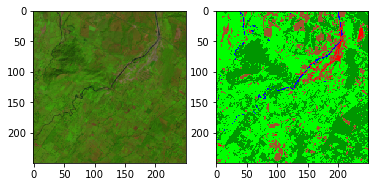

In [30]:
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (0, 150, 0, 255)),  # Forest
    (2, (0, 0, 255, 255)),  # Water
    (3, (0, 255, 0, 255)),  # Herbaceous
    (4, (160, 82, 45, 255)),  # Barren
    (5, (255, 0, 0, 255))  # Urban
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img543)

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()